In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

C:\Users\Owner\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [5]:
df = pd.read_csv('all_en_lyrics_processed.csv')
print(f"Data loaded: {df.shape[0]} songs, {df.shape[1]} columns")

Data loaded: 10872 songs, 15 columns


In [7]:
def prepare_features(df, text_features=True, numerical_features=True, max_features=100):
    feature_list = []
    feature_names = []

    if text_features and 'clean_lyrics' in df.columns:
        vectorizer = TfidfVectorizer(
            max_features=max_features,
            stop_words='english',
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.8
        )
        lyrics = df['clean_lyrics'].fillna('')
        tfidf_matrix = vectorizer.fit_transform(lyrics)
        feature_list.append(tfidf_matrix.toarray())
        feature_names.extend([f"tfidf_{word}" for word in vectorizer.get_feature_names_out()])

    numerical_cols = []
    if numerical_features:
        if 'year' not in df.columns and 'date' in df.columns:
            df['year'] = pd.to_datetime(df['date'], errors='coerce').dt.year

        for col in ['duration', 'sentiment_score', 'year']:
            if col in df.columns:
                numerical_cols.append(col)

        if numerical_cols:
            numerical_data = df[numerical_cols].fillna(df[numerical_cols].median())
            feature_list.append(numerical_data.values)
            feature_names.extend(numerical_cols)

    if not feature_list:
        raise ValueError("No features could be prepared from the data")

    features = np.hstack(feature_list)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    return scaled_features, feature_names

In [9]:
scaled_features, feature_names = prepare_features(df)

In [15]:
def find_optimal_k(scaled_features, k_range=range(2, 11)):
    inertias = []
    silhouette_scores = []

    for k in k_range:
        print(f"Testing k={k}...")
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(scaled_features)
        inertias.append(kmeans.inertia_)
        score = silhouette_score(scaled_features, cluster_labels)
        silhouette_scores.append(score)
        print(f"  Silhouette Score: {score:.3f}")

    best_k = k_range[np.argmax(silhouette_scores)]

    # Plot results
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
    # Elbow plot
    axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
    axes[0].set_xlabel('Number of Clusters (k)')
    axes[0].set_ylabel('Inertia (Within-cluster Sum of Squares)')
    axes[0].set_title('Elbow Method for Optimal k')
    axes[0].grid(False)
        
    # Silhouette plot
    axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
    axes[1].set_xlabel('Number of Clusters (k)')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].set_title('Silhouette Analysis for Optimal k')
    axes[1].grid(False)
        
    # Highlight best silhouette score
    best_k = k_range[np.argmax(silhouette_scores)]
    best_score = max(silhouette_scores)
    axes[1].axvline(x=best_k, color='red', linestyle='--', alpha=0.7)
    axes[1].text(best_k, best_score, f'Best k={best_k}\nScore={best_score:.3f}', 
                ha='center', va='bottom', fontweight='bold')
        
    plt.tight_layout()
    plt.savefig('Silhouette Analysis for Optimal k.png')
    plt.show()

    return best_k

Testing k=2...
  Silhouette Score: 0.071
Testing k=3...
  Silhouette Score: 0.080
Testing k=4...
  Silhouette Score: 0.027
Testing k=5...
  Silhouette Score: 0.032
Testing k=6...
  Silhouette Score: 0.032
Testing k=7...
  Silhouette Score: 0.029
Testing k=8...
  Silhouette Score: 0.006
Testing k=9...
  Silhouette Score: 0.009
Testing k=10...
  Silhouette Score: 0.005


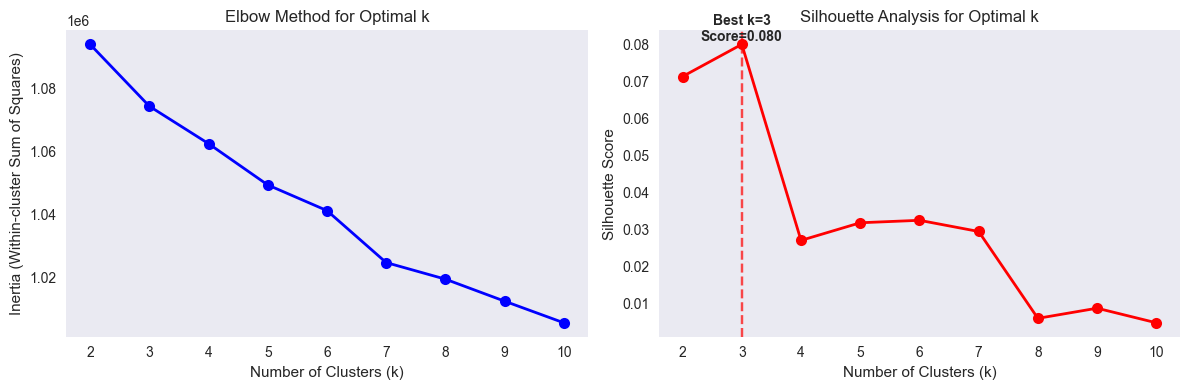

In [17]:
best_k = find_optimal_k(scaled_features)

In [27]:
def perform_clustering(scaled_features, df, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_features)
    
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    sample_scores = silhouette_samples(scaled_features, cluster_labels)
    
    df['cluster'] = cluster_labels
    df['silhouette_score'] = sample_scores
    
    return df, kmeans, silhouette_avg, cluster_labels, sample_scores

In [29]:
df, kmeans, avg_score, cluster_labels, silhouette_scores = perform_clustering(scaled_features, df, best_k)

In [31]:
def visualize_clusters(scaled_features, cluster_labels, kmeans):
    pca = PCA(n_components=2, random_state=42)
    features_2d = pca.fit_transform(scaled_features)

    plt.figure(figsize=(10, 6))
    for i in np.unique(cluster_labels):
        plt.scatter(features_2d[cluster_labels == i, 0],
                    features_2d[cluster_labels == i, 1], label=f'Cluster {i}', alpha=0.6)

    centers_2d = pca.transform(kmeans.cluster_centers_)
    plt.scatter(centers_2d[:, 0], centers_2d[:, 1], 
                c='red', marker='x', s=200, linewidths=3, label='Centroids')
        
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title('K-means Clustering Visualization (PCA)')
    plt.legend()
    plt.grid(False)
    plt.tight_layout()
    plt.savefig('K-means Clustering Visualization (PCA).png')
    plt.show()
        
    print(f"PCA explains {pca.explained_variance_ratio_.sum():.2%} of total variance") 

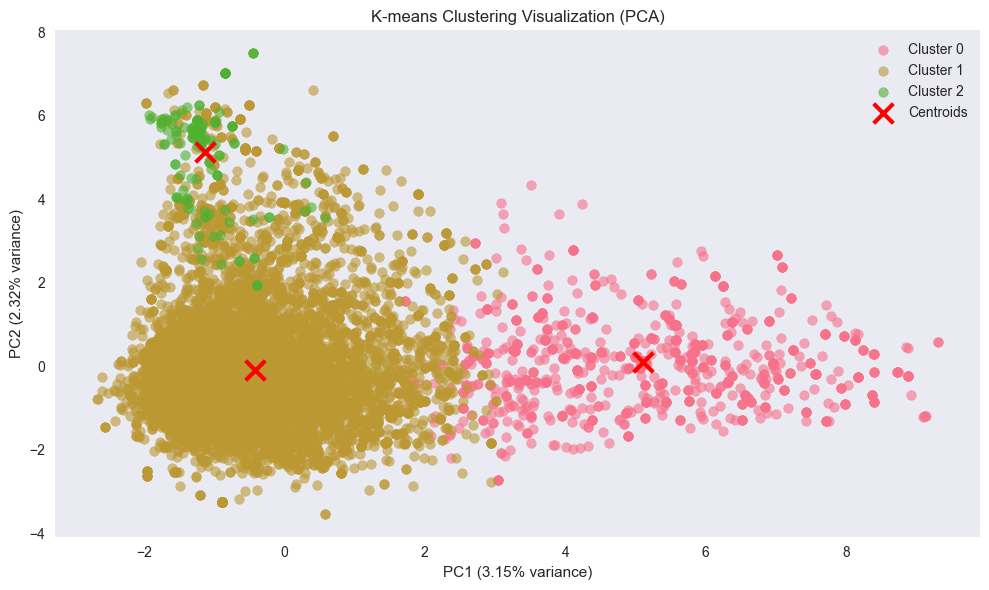

PCA explains 5.47% of total variance


In [33]:
visualize_clusters(scaled_features, cluster_labels, kmeans)

In [3]:
# Old version
#def visualize_clusters_2d(self):
        
#    n_clusters = len(np.unique(cluster_labels))
#    colors = plt.cm.Set3(np.linspace(0, 1, n_clusters))
        
#    for i in range(n_clusters):
#        cluster_data = features_2d[self.cluster_labels == i]
#        plt.scatter(cluster_data[:, 0], cluster_data[:, 1], 
#                    c=[colors[i]], label=f'Cluster {i}', 
#                    alpha=0.7, s=50)   
# Previous variance was 3.41%, so this is improvement! Also incorporated a new, third cluster

In [43]:
def plot_silhouette_analysis(cluster_labels, silhouette_scores):
    n_clusters = len(np.unique(cluster_labels))
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    y_lower = 10
    colors = plt.cm.Set3(np.linspace(0, 1, n_clusters))

    for i in range(n_clusters):
        cluster_silhouette_values = silhouette_scores[cluster_labels == i]
        cluster_silhouette_values.sort()
        size_cluster_i = cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values,
                         facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontweight='bold')
        y_lower = y_upper + 10

    avg_score = np.mean(silhouette_scores)
    ax.axvline(x=avg_score, color="red", linestyle="--", label=f'Average Score: {avg_score:.3f}')
    ax.set_xlabel('Silhouette Coefficient Values')
    ax.set_ylabel('Cluster Label')
    ax.set_title(f'Silhouette Analysis (k={n_clusters})\nAverage Score: {avg_score:.3f}')
    ax.legend()
    plt.tight_layout()
    plt.savefig(f'Silhouette Analysis (k={n_clusters}) Average Score: {avg_score:.3f}.png')
    plt.show()

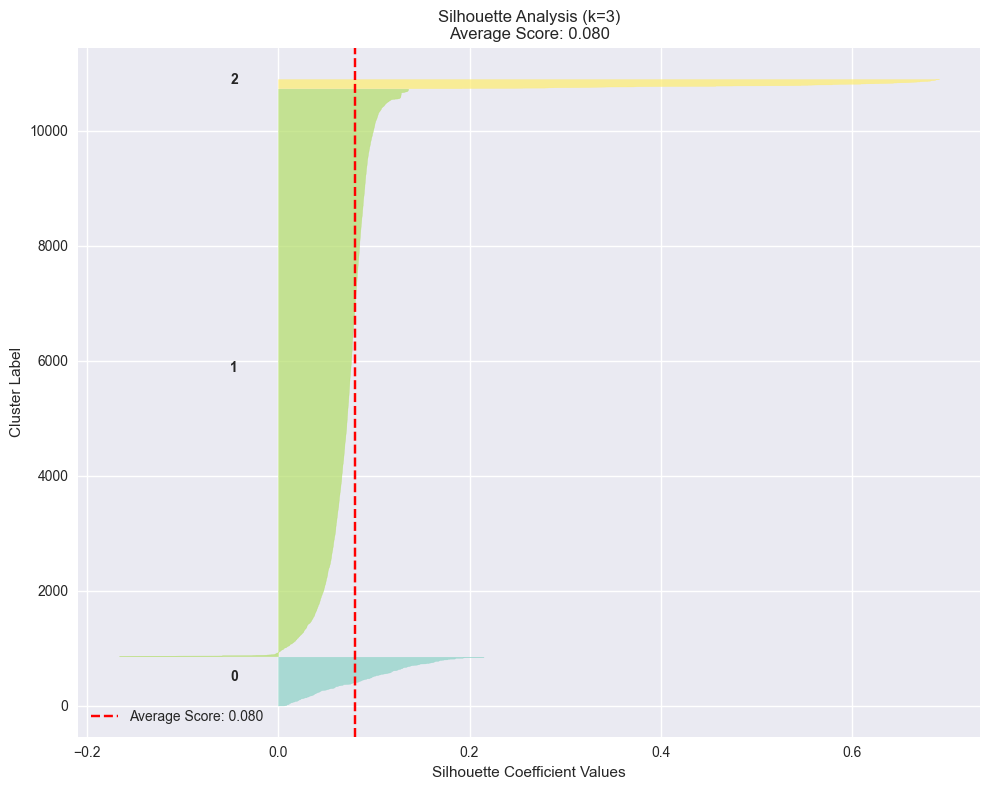

In [45]:
plot_silhouette_analysis(cluster_labels, silhouette_scores)

In [47]:
def analyze_clusters(df):
    print("Cluster Analysis:")
    n_clusters = df['cluster'].nunique()
    for cluster_id in range(n_clusters):
        cluster_data = df[df['cluster'] == cluster_id]
        print(f"\nCluster {cluster_id} ({len(cluster_data)} songs):")
        print("-" * 40)
        if 'artist' in df.columns:
            top_artists = cluster_data['artist'].value_counts().head(3)
            print("Top Artists:", dict(top_artists))
        if 'genre' in df.columns:
            top_genres = cluster_data['genre'].value_counts().head(3)
            print("Top Genres:", dict(top_genres))
        if 'sentiment_score' in df.columns:
            avg_sentiment = cluster_data['sentiment_score'].mean()
            print(f"Average Sentiment: {avg_sentiment:.3f}")
        if 'duration' in df.columns:
            avg_duration = cluster_data['duration'].mean() / 1000 / 60
            print(f"Average Duration: {avg_duration:.1f} minutes")
        if 'title' in df.columns:
            sample_songs = cluster_data['title'].sample(3).tolist()
            print("Sample Songs:", sample_songs)
        if 'silhouette_score' in df.columns:
            cluster_silhouette = cluster_data['silhouette_score'].mean()
            print(f"Cluster Silhouette Score: {cluster_silhouette:.3f}")

In [49]:
analyze_clusters(df)

Cluster Analysis:

Cluster 0 (847 songs):
----------------------------------------
Top Artists: {'Latto': 60, 'KUR': 52, 'Belly Gang Kushington': 52}
Top Genres: {'Hip Hop': 49, 'Rock': 15, 'Pop': 4}
Average Sentiment: -0.903
Average Duration: 3.1 minutes
Sample Songs: ['Big Pun Freestyle', 'Fluent', 'Bob Hope']
Cluster Silhouette Score: 0.086

Cluster 1 (9868 songs):
----------------------------------------
Top Artists: {'Ayreon': 132, 'R.E.M.': 104, 'Beyoncé': 99}
Top Genres: {'Rock': 486, 'Rock, Pop': 293, 'Electronic': 156}
Average Sentiment: -0.275
Average Duration: 3.5 minutes
Sample Songs: ['When You Dance', 'Through the Long and Lonely Night (The Legend of Ochi)', 'Tyrant']
Cluster Silhouette Score: 0.072

Cluster 2 (157 songs):
----------------------------------------
Top Artists: {'Tom Meighan': 12, 'almost monday': 12, 'LISA': 8}
Top Genres: {'Rock': 7, 'Rock, Pop': 4, "Pop, Children's": 4}
Average Sentiment: -0.298
Average Duration: 3.3 minutes
Sample Songs: ['Where’d You G

In [51]:
df.to_csv('Silhouette_scores_kmeans_results.csv', index=False)